In [1]:
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.benchmarks.tools import igd
from deap.tools import ParetoFront
from math import factorial
import warnings
from collections import defaultdict
import seaborn as sns
from shapely.geometry import LineString
import contextily as ctx
from mpl_toolkits.mplot3d import Axes3D
import random
import geopandas as gpd

warnings.filterwarnings('ignore')

We need to load our data, firstly our travel times which we have in a pre-calculated table

In [2]:
# Read in the travel times data
travel_times = pd.read_csv('./GP_Travel_Times.csv')
travel_times = travel_times.dropna()

We can turn this in to a dictionary which will help performance

In [3]:
travel_times_dict = {(row["Home_LSOA"], row["Site_LSOA"]): row["TT"] for _, row in travel_times.iterrows()}

Let us load and process our data about our sites

In [4]:
#load to a data frame
sites = pd.read_csv('./Sites.csv', encoding='ISO-8859-1')
#remove unnecessary columns
sites = sites.loc[:, ['UnitCode', 'LSOA','NICU','LCU','SCBU']]

#Apply data cleansing
sites = sites.replace('', np.nan)
sites = sites.dropna()

sites.head()

,UnitCode,LSOA,NICU,LCU,SCBU
0,RBL14,E01007251,6,8,10
1,RJR06,E01018377,1,2,10
2,RBT20,E01018480,3,4,8
3,REP01,E01006512,12,12,20
4,RJN71,E01018616,0,1,7


And our activities data 

In [5]:

#Load to a data frame
activities = pd.read_csv('./Badgernet_Activity.csv', encoding='ISO-8859-1')

#Remove unecessary columns
activities_orig = activities.loc[:, ['Der_Postcode_LSOA_Code','CC_Activity_Date','SiteLSOA', 'CC_Level']]
activities = activities.loc[:, ['Der_Postcode_LSOA_Code','CC_Activity_Date','SiteLSOA', 'CC_Level']]

#Apply data cleansing
activities = activities.replace('', np.nan)
activities = activities.dropna()

# Ensure the date is a date
activities['CC_Activity_Date'] = pd.to_datetime(activities['CC_Activity_Date'], format='%d/%m/%Y')
activities = activities.set_index('Der_Postcode_LSOA_Code')

#Lets define the time periods for the analysis
start_date = pd.Timestamp('2019-04-01')
end_date = pd.Timestamp('2022-03-31')
time_periods = pd.date_range(start_date, end_date, freq='D')

filtered_activities = activities.loc[(activities['CC_Activity_Date'] >= start_date) & (activities['CC_Activity_Date'] <= end_date)]


We'll split these up into daily groups

In [6]:
daily_activities = []
for _, daily_df in activities.groupby('CC_Activity_Date'):
    daily_activities.append(daily_df)


We need to establish some functions to solve the absolute nearest site for each home LSOA

In [7]:

def assign_nearest_site(travel_times_dict, sites_df, activities_df):
    # Get unique home locations from the activities data
    unique_home_lsoa = activities_df.index.unique()

    # Convert the dictionary of travel times into a DataFrame for easier processing
    travel_times_df = pd.DataFrame(list(travel_times_dict.items()), columns=['LSOA', 'Time'])
    # Split the 'LSOA' column into separate 'home_lsoa' and 'site_lsoa' columns
    travel_times_df[['home_lsoa', 'site_lsoa']] = pd.DataFrame(travel_times_df['LSOA'].tolist(), index=travel_times_df.index)
    # Drop the now redundant 'LSOA' column
    travel_times_df.drop(columns='LSOA', inplace=True)

    # Transform the DataFrame into a pivot table where rows represent homes and columns represent sites
    travel_times_df_pivoted = travel_times_df.pivot(index='home_lsoa', columns='site_lsoa', values='Time')

    # For each home, find the site with the shortest travel time
    nearest_site_dict = travel_times_df_pivoted.idxmin(axis=1).to_dict()

    # For each activity in the DataFrame, assign the nearest site
    activities_df['nearest_site'] = activities_df.index.map(nearest_site_dict)

    return activities_df

def assign_nearest_site_daily(travel_times_dict, sites_df, daily_activities_list):
    # For each day, assign the nearest site to each activity
    return [assign_nearest_site(travel_times_dict, sites_df, activities_df) for activities_df in daily_activities_list]

def calculate_daily_average(daily_activities_with_site):
    # For each day, count the number of activities at each site for each CC level
    daily_counts = [daily_df.groupby(['nearest_site', 'CC_Level']).size() for daily_df in daily_activities_with_site]

    # Concatenate the counts from all days into a single DataFrame and calculate the average count for each site and CC level
    average_daily_activities = pd.concat(daily_counts, axis=1).mean(axis=1).reset_index(name='Average_Activities')
    return average_daily_activities




And run them.

In [8]:
# Assign the nearest site to each activity for each day
daily_activities_with_site = assign_nearest_site_daily(travel_times_dict, sites, daily_activities)

# Calculate the average number of daily activities at each site
average_daily_activities = calculate_daily_average(daily_activities_with_site)

Next we will look at those assigned sites and calculate the average journey time across all activities, this will give us a basis for assessment of our later solutions, but bearing in mind that this absolutely optimised solution is not realistic as it takes none of our other objectives into account.

In [9]:
total_travel_time = 0
total_activities = 0

# For each day
for daily_df in daily_activities_with_site:
    # For each activity
    for idx, row in daily_df.iterrows():
        home = idx
        site = row['nearest_site']
        # Check if site is not 'nan'
        if pd.notna(site):
            # Add the travel time from the home location to the assigned site to the total
            total_travel_time += travel_times_dict[(home, site)]
            total_activities += 1

average_travel_time = total_travel_time / total_activities if total_activities != 0 else 0

print(f"The maximally optimised minimum average travel time is {average_travel_time} minutes per site assignment")

The maximally optimised minimum average travel time is 15.435713853541507 minutes per site assignment


Lets plot the daily average demands on each site for this solution 

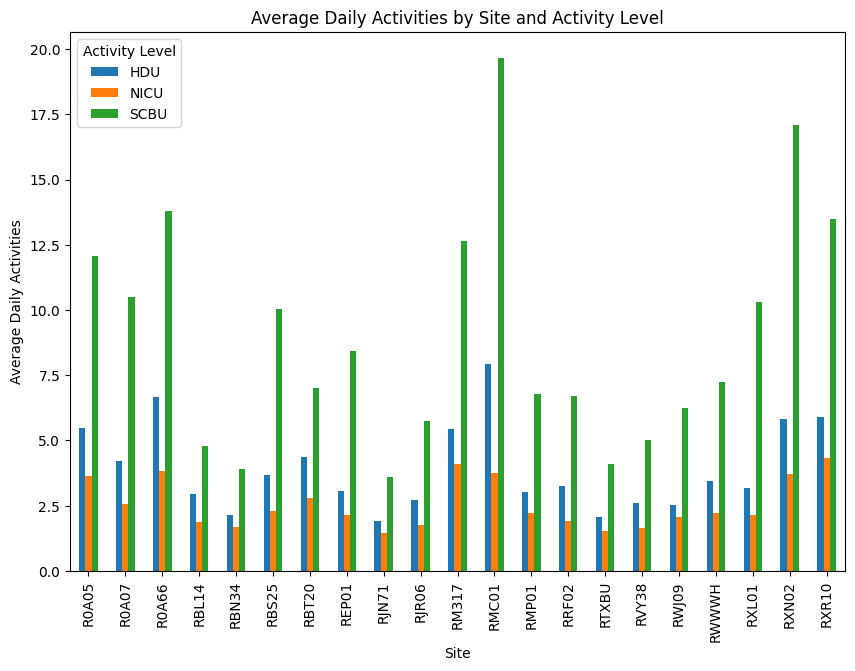

In [10]:
# Create a dictionary that maps 'LSOA' to 'UnitCode'
site_mapping = sites.set_index('LSOA')['UnitCode'].to_dict()

# Replace 'LSOA' with 'UnitCode' in the 'nearest_site' column
average_daily_activities['nearest_site'] = average_daily_activities['nearest_site'].map(site_mapping)

# First, pivot the DataFrame to get a better format for the bar chart
pivot_df = average_daily_activities.pivot(index='nearest_site', columns='CC_Level', values='Average_Activities')

# Now we create the bar chart using pandas plot function
pivot_df.plot(kind='bar', stacked=False, figsize=(10,7))

plt.title('Average Daily Activities by Site and Activity Level')
plt.xlabel('Site')
plt.ylabel('Average Daily Activities')
plt.legend(title='Activity Level')

plt.show()

And lets see how that looks on a map, first lets simplify our data to unique assignments

In [11]:
# Concatenate the list of dataframes into one dataframe
concat_df = pd.concat(daily_activities_with_site)

# Get unique assignments
unique_assignments_dict = concat_df[['nearest_site']].reset_index().drop_duplicates().set_index('Der_Postcode_LSOA_Code').to_dict()['nearest_site']
unique_assignments_list = list(concat_df[['nearest_site']].reset_index().drop_duplicates().itertuples(index=False, name=None))

Load and organise our geographic information 

In [12]:
# Load the LSOA shape file
lsoas = gpd.read_file('./LSOA_Dec_2011_PWC_in_England_and_Wales/LSOA_Dec_2011_PWC_in_England_and_Wales.shp')

# Make a list of all our homes and sites
site_codes = sites['LSOA'].unique().tolist()
home_codes =  activities.index.unique().tolist()

# Make a sites GeoDF
sites_geo_df = lsoas[lsoas['lsoa11cd'].isin(site_codes)]
sites_geo_df = sites_geo_df.set_index('lsoa11cd')
sites_geo_df['centroid'] = sites_geo_df.geometry.centroid

# Make a homes GeoDF
homes_geo_df = lsoas[lsoas['lsoa11cd'].isin(home_codes)]
homes_geo_df = homes_geo_df.set_index('lsoa11cd')
homes_geo_df['centroid'] = homes_geo_df.geometry.centroid

homes_geo_df.crs = "EPSG:27700"
sites_geo_df.crs = "EPSG:27700"

# # homes_geo_df['geometry'] = homes_geo_df['geometry'].apply(lambda geom: shapely.ops.transform(lambda x, y: (y, x), geom))
# # sites_geo_df['geometry'] = sites_geo_df['geometry'].apply(lambda geom: shapely.ops.transform(lambda x, y: (y, x), geom))

homes_geo_df = homes_geo_df.to_crs(epsg=3857)
sites_geo_df = sites_geo_df.to_crs(epsg=3857)

In [13]:
homes_geo_df.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

And we can then plot the assignments on a map

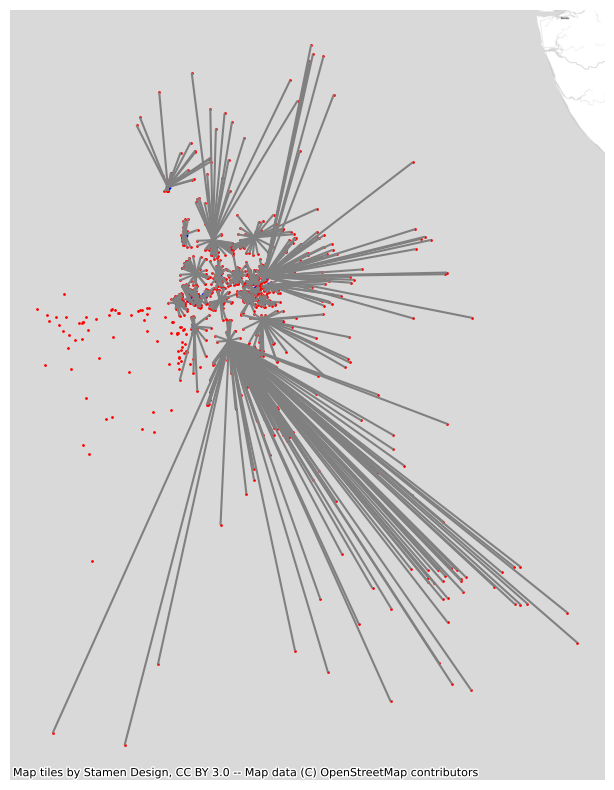

In [14]:
fig, ax = plt.subplots(figsize=(10,10))

# plot the homes
homes_geo_df['centroid'].plot(ax=ax, color='red', markersize=1)

# plot lines from home to site
for home, site in unique_assignments_list:
    if home in homes_geo_df.index and site in sites_geo_df.index:
        coords = [homes_geo_df.loc[home, 'centroid'].coords[0], sites_geo_df.loc[site, 'centroid'].coords[0]]
        line = LineString(coords)
        gpd.GeoSeries(line).plot(ax=ax, color='grey')

# plot the sites
sites_geo_df['centroid'].plot(ax=ax, color='blue', markersize=10)

# add the basemap
ctx.add_basemap(ax, crs=homes_geo_df.crs.to_string(), zoom=10, source=ctx.providers.Stamen.TonerLite)

ax.set_aspect('equal')

# remove the axis markers
ax.axis('off')

plt.show()

So our simple nearest assignment has distinct limitations and does not allow us to balance any other competing priorities. 

This kind of problem is a variant of the travelling salesman problem (https://en.wikipedia.org/wiki/Travelling_salesman_problem) which is NP-Hard meaning that it is too computationally expensive to compute all possible solutions and find the best one. Therefore needs to be approached and solved using a heuristic approach.

For this purpose we are going to use a genetic algorithm to enable us to balance competing priorities and come up with a balanced good solution. 

We will need to define the parameters for our genetic algorithm

    * Population Size
    * Chance to cross breed
    * Mutation Probability
    * How many generations to breed

In [15]:
# Let us set up sone of the parameters for the evolution of our solution
# number of solutions in a population
pop_num = 100
# percentage chance to cross breed one solution with another
cross_chance = 0.5
# percentage chance to introduce random mutations into the solutions
mutation_prob = 0.1
# the number of generations to run the evolution for
number_generations = 50

And do some more data preparation, as we are now concerned with looking at the different levels of care in assignment rather than our crude previous method to establish a baseline for that single metric

In [16]:
# Number of homes and sites
home_lsoas = filtered_activities.index.unique().tolist()
num_homes = len(home_lsoas)
num_sites = len(site_codes)

activity_to_int = {activity: i for i, activity in enumerate(activities['CC_Level'].unique())} # Not being used
int_to_activity = {i: activity for i, activity in enumerate(activities['CC_Level'].unique())}

# Group by DER_Postcode_LSOA_Code and count the occurrences
home_populations_dict = activities.groupby('Der_Postcode_LSOA_Code').size().to_dict()
home_activities_dict = activities.groupby('Der_Postcode_LSOA_Code')['CC_Level'].value_counts().unstack(fill_value=0).to_dict(orient='index')
home_activities = [[home_activities_dict[home][int_to_activity[i]] for i in range(3)] for home in home_lsoas]

# Convert it to list matching the order of home_lsoas
home_populations = [home_populations_dict[home] for home in home_lsoas]

Now we will set up and run our evolutionary algorithm. The most important part is the custom evaluation function. Most of the population, generations, breeding and mutating is handled by the DEAP library, but we need to define our own custom function to assess the fitness of each solution. These scores are then used to find the best individual solutions in each generation to breed off and mutate in later generations to evelove the population towards a 'good' solution to our problem with competing priorities.

First we will add in 2 priorities:
    * Minimise the average travel time 
    * Maximise the number of mothers within 30 minutes 

In [19]:

# For multi-objective: minimize time, maximize the number of people within 30 minutes
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, 1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

toolbox.register("random_site", random.randint, 0, num_sites-1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.random_site, num_homes)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

logs_df = pd.DataFrame(columns=['individual', 'avg_time', 'prop_within_30_mins', 'assignments'])

def eval_func(individual):
    total_time = 0    # Accumulator for total travel time
    total_population = 0   # Accumulator for total population 
    activity_counts = defaultdict(lambda: [0, 0, 0])  # Default dictionary for keeping track of activity counts at each site
    within_30_mins = 0   # Counter for population within 30 minutes travel time 
    # Loop over each home's assigned site in the individual
    for home_idx, site_idx in enumerate(individual):
        # Get the home and site codes from their respective lists
        home = home_lsoas[home_idx]
        site = site_codes[site_idx]
        # If we have the travel time for this home and site
        if (home, site) in travel_times_dict:
            # Get the travel time
            travel_time = travel_times_dict[(home, site)]
            # Add the total travel time for the population at this home
            total_time += travel_time * home_populations[home_idx]
            # Add this home's population to the total population
            total_population += home_populations[home_idx]
            # If the travel time is less than or equal to 30 mins, add this home's population to within_30_mins
            if travel_time <= 30:
                within_30_mins += home_populations[home_idx]
            # Get this home's activity counts
            activity_counts_per_home = home_activities[home_idx]  
            # For each activity type, add this home's count of that activity to the site's total count
            for i, activity in enumerate(['HDU', 'NICU', 'SCBU']):
                activity_counts[site][i] += activity_counts_per_home[i]
    # Calculate the average travel time (or 0 if total_population is 0)
    avg_time = total_time / total_population if total_population != 0 else 0
    # Calculate the proportion of the population within 30 minutes travel time (or 0 if total_population is 0)
    prop_within_30_mins = within_30_mins / total_population if total_population != 0 else 0

    global logs_df  

    
    # Add a new row to the DataFrame
    logs_df = logs_df.append({
        'individual': individual,  
        'avg_time': avg_time,
        'prop_within_30_mins': prop_within_30_mins,
        'assignments': {home_lsoas[i]: site_codes[individual[i]] for i in range(len(individual))}
    }, ignore_index=True)
    
    return avg_time, prop_within_30_mins


toolbox.register("evaluate", eval_func)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=num_sites-1, indpb=0.2)
toolbox.register("select", tools.selNSGA2)


def main():
    random.seed(42)
    pop = toolbox.population(n=pop_num)
    hof = tools.HallOfFame(1)
    hof2 = ParetoFront()

    # Define statistics for each objective
    stats_time = tools.Statistics(key=lambda ind: ind.fitness.values[0])
    stats_time.register("avg_time", np.mean)

    stats_prop = tools.Statistics(key=lambda ind: ind.fitness.values[1])
    stats_prop.register("prop_within_30_mins", np.mean)
    
    # Combine statistics into MultiStatistics
    mstats = tools.MultiStatistics(time=stats_time, prop=stats_prop)
    
    # Use mstats instead of the previous stats object
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=cross_chance, mutpb=mutation_prob, ngen=number_generations, 
                                   stats=mstats, halloffame=hof, verbose=False)
    
    # Manually update the Pareto front
    hof2.update(pop)
    
    return pop, log, hof, hof2


pop, log, hof, hof2 = main()
#print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
fitnesses = [ind.fitness for ind in pop]
best_ind_id = fitnesses.index(max(fitnesses))
best_ind = pop[best_ind_id]
print(f"Best individual is at index {best_ind_id} with fitness: {best_ind.fitness}")


Best individual is at index 0 with fitness: (53.34930925256111, 0.2134261390822342)


Lets have a look at our best individual in more detail to understand the reality of the home to site mappings

In [20]:

#print("Pareto front:")
#for individual in hof2:
#    print(individual)

# Here we translate the best individual (which is a list of site indices) into a list of (home_code, site_code) pairs
solution = []
for i, site_index in enumerate(hof[0]):
    home_code = home_lsoas[i]
    site_code = site_codes[site_index]
    solution.append((home_code, site_code))
    
# Now we can create a dictionary that maps each home to a site
home_to_site_mapping = dict(solution)

# Now you can print this mapping or use it in further processing
# print("Home to site mapping:")
# print(home_to_site_mapping)

# Next, let's count the number of activities at each site
activity_counts = defaultdict(lambda: [0, 0, 0])
for home_code, site_code in solution:
    activity_counts_per_home = home_activities_dict[home_code]  # get this home's activity counts
    for i in range(3):  # for each type of activity
        activity_counts[site_code][i] += activity_counts_per_home[int_to_activity[i]]

print("Activity counts per site:")
print(activity_counts)

# Initialize the dictionary
home_to_site_mapping = defaultdict(list)

# Go through each (home_code, site_code) pair in the solution list
for home_code, site_code in solution:
    # Add the home code to the list of homes assigned to this site
    home_to_site_mapping[site_code].append(home_code)

print("Home to site mapping:")
print(home_to_site_mapping)

Activity counts per site:
defaultdict(<function <lambda> at 0x000001B2FC6E83A0>, {'E01006499': [4569, 12387, 2978], 'E01005164': [5720, 12869, 3319], 'E01025104': [4141, 10950, 2752], 'E01005801': [8159, 19268, 4961], 'E01012722': [3160, 8018, 1640], 'E01006570': [4427, 10583, 2687], 'E01018480': [3247, 8242, 1669], 'E01005062': [5150, 10724, 2916], 'E01005070': [5625, 11485, 3000], 'E01019155': [2201, 5497, 1147], 'E01024897': [3239, 8075, 1657], 'E01012457': [3852, 8096, 2171], 'E01006512': [3950, 10430, 2391], 'E01007251': [3576, 7434, 2117], 'E01005354': [3947, 8881, 2439], 'E01006370': [3276, 8723, 2429], 'E01018616': [6873, 14239, 4401], 'E01018377': [4686, 11327, 2873], 'E01025488': [5859, 12326, 3526], 'E01005944': [3012, 6878, 1434], 'E01025300': [4021, 10510, 2048], 'E01004880': [3854, 10024, 2503]})
Home to site mapping:
defaultdict(<class 'list'>, {'E01006499': ['E01005338', 'E01005729', 'E01018442', 'E01006803', 'E01006435', 'E01019715', 'E01025104', 'E01006231', 'E0100649

It is useful now we have competing priorities to visualise the Pareto Front, this is the edge along which in the solution space, a move which is positive for one objective is negative for the competing objective and where those limits are.

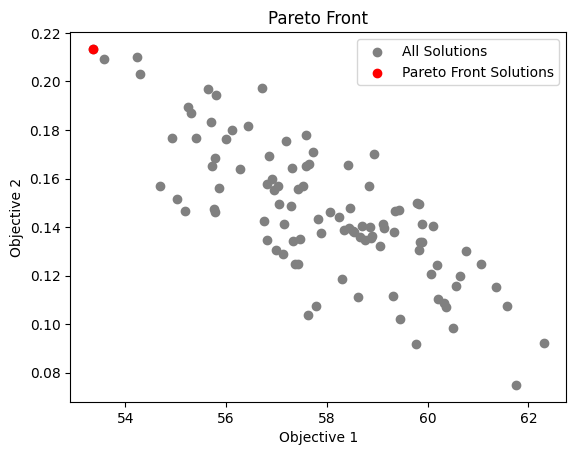

In [21]:
objectives_pareto = [ind.fitness.values for ind in hof2]
objectives_all = [ind.fitness.values for ind in pop]

plt.scatter([obj[0] for obj in objectives_all],
            [obj[1] for obj in objectives_all],
            c='grey', label='All Solutions')

plt.scatter([obj[0] for obj in objectives_pareto],
            [obj[1] for obj in objectives_pareto],
            c='red', label='Pareto Front Solutions')

plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.title('Pareto Front')
plt.legend()
plt.show()

In [22]:



best_individual_solution = {home_lsoas[i]: site_codes[best_ind[i]] for i in range(len(best_ind))}

# Create a DataFrame from the best individual solution that maps home to site
home_to_site_df = pd.DataFrame(list(best_individual_solution.items()), columns=['HomeCode', 'SiteCode'])

# Initialize the total activity counts
total_activity_counts = defaultdict(lambda: [0, 0, 0])

# Iterate through the daily activities
for daily_df in daily_activities:
    # Merge the daily DataFrame with the home_to_site_df to add the site codes
    daily_with_site = daily_df.reset_index().merge(home_to_site_df, left_on='Der_Postcode_LSOA_Code', right_on='HomeCode')
    
    # Drop the SiteCode_x column and rename SiteCode_y to SiteCode
    daily_with_site.drop(columns=['HomeCode'], inplace=True)
    
    # Use pivot_table to compute the counts for each combination of site and activity level
    activity_counts_pivot = daily_with_site.pivot_table(index='SiteCode', columns='CC_Level', aggfunc='size', fill_value=0)

    # Update the total activity counts with the daily counts
    for site_code, counts in activity_counts_pivot.iterrows():
        total_activity_counts[site_code][0] += counts.get('NICU', 0)
        total_activity_counts[site_code][1] += counts.get('HDU', 0)
        total_activity_counts[site_code][2] += counts.get('SCBU', 0)

# Compute the average daily activity counts
average_daily_activity_counts = {site_code: [count / len(daily_activities) for count in counts] for site_code, counts in total_activity_counts.items()}

# Print the results
print("Average daily activity counts per site:")
print(average_daily_activity_counts)


Average daily activity counts per site:
{'E01005944': [2.235294117647059, 3.996078431372549, 8.64549019607843], 'E01025488': [2.292549019607843, 4.056470588235294, 8.733333333333333], 'E01006512': [1.847843137254902, 2.9576470588235293, 6.967843137254902], 'E01025104': [2.450980392156863, 4.530980392156863, 9.392941176470588], 'E01025300': [2.1176470588235294, 3.156078431372549, 7.804705882352941], 'E01005062': [2.0988235294117645, 3.0619607843137255, 8.861176470588235], 'E01005070': [1.6933333333333334, 3.292549019607843, 7.4101960784313725], 'E01005164': [1.5662745098039215, 2.8172549019607844, 5.923921568627451], 'E01005801': [1.8847058823529412, 2.883921568627451, 7.392156862745098], 'E01019155': [1.2980392156862746, 1.7411764705882353, 4.52078431372549], 'E01004880': [1.5741176470588236, 4.193725490196078, 8.221176470588235], 'E01024897': [2.0549019607843135, 3.311372549019608, 8.379607843137254], 'E01005354': [2.4196078431372547, 3.6831372549019608, 7.8792156862745095], 'E0100657

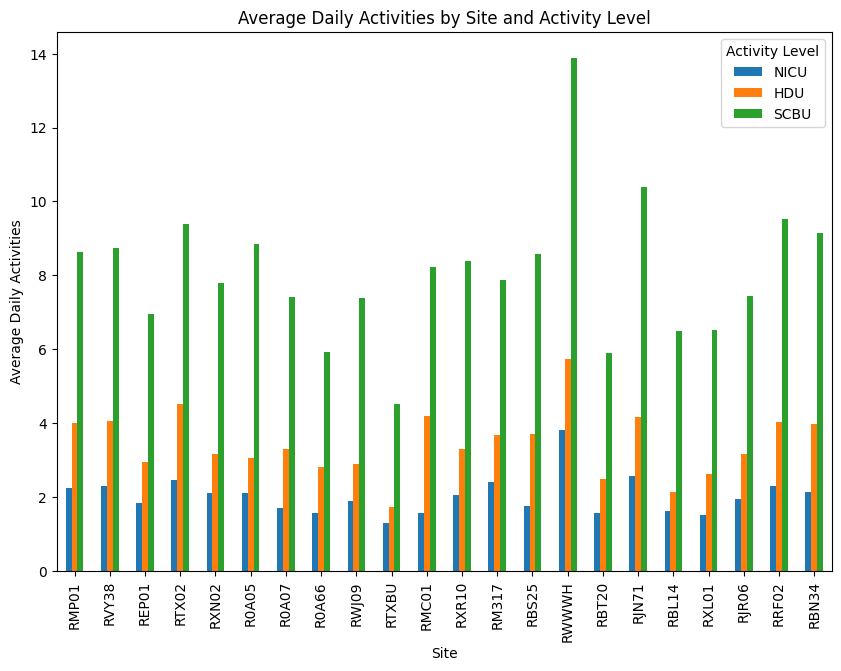

In [23]:

# Convert the average_daily_activity_counts dictionary into a DataFrame
average_daily_activities_df = pd.DataFrame.from_dict(average_daily_activity_counts, orient='index', columns=['NICU', 'HDU', 'SCBU'])

# Reset the index to make 'SiteCode' a column
average_daily_activities_df.reset_index(inplace=True)
average_daily_activities_df.rename(columns={'index': 'SiteCode'}, inplace=True)
average_daily_activities_df['SiteCode'] = average_daily_activities_df['SiteCode'].map(site_mapping)

# Plot the DataFrame directly using pandas plot function
average_daily_activities_df.set_index('SiteCode').plot(kind='bar', stacked=False, figsize=(10,7))

plt.title('Average Daily Activities by Site and Activity Level')
plt.xlabel('Site')
plt.ylabel('Average Daily Activities')
plt.legend(title='Activity Level')

plt.show()


In [24]:
unique_activity_levels = set()
for daily_df in daily_activities:
    unique_activity_levels.update(daily_df['CC_Level'].unique())

print("Unique activity levels across all daily DataFrames:", unique_activity_levels)


Unique activity levels across all daily DataFrames: {'HDU', 'NICU', 'SCBU'}


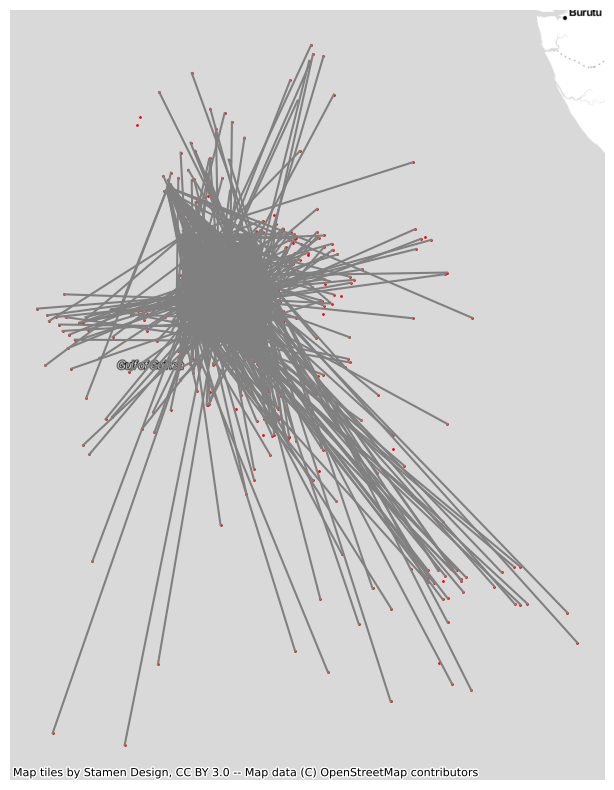

In [25]:
def plot_assignments(individual):
    
    fig, ax = plt.subplots(figsize=(10,10))
    
    # Plot the LSOAs
    homes_geo_df.boundary.plot(ax=ax, color='blue')
    
    # plot the homes
    homes_geo_df['centroid'].plot(ax=ax, color='red', markersize=1)

    # Plot the sites
    sites_geo_df.boundary.plot(ax=ax, color='red')

    # For each home in the individual, draw a line from the home to the assigned site
    for home_idx, site_idx in enumerate(individual):
        home = home_lsoas[home_idx]
        site = site_codes[site_idx]
                                                                                                                                                                                                                                                                                                                        
        # Try to get the coordinates of the home and the site
        try:
            home_coords = homes_geo_df.loc[home, 'centroid'].coords[0]
        except KeyError as e:
            #print(f"Failed to get coordinates for home {home}: {e}")
            continue

        try:
            site_coords = sites_geo_df.loc[site, 'centroid'].coords[0]
        except KeyError as e:
            #print(f"Failed to get coordinates for site {site}: {e}")
            continue

        # Draw a line between the home and the site
        plt.plot([home_coords[0], site_coords[0]], [home_coords[1], site_coords[1]], color='grey')

    # Add a background map
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
    
  
    ax.set_aspect('equal')

    # remove the axis markers
    ax.axis('off')
    
    # Show the plot
    plt.show()

# Use the function
plot_assignments(pop[best_ind_id])

Lets add our other competing priorities in to our evaluation function

We want to:

    * Minimise the average travel time
    * Maximise the proportion within 30 minutes
    * Minimise the maximum distance for any assignment
    * Maximise the number taking place in units with more than x admissions per year
    * Maximise the smallest number of admissions per year  
    * Minimise the largest number of admissions per year 
    * Maximise the proportion within 30 minutes and in units with more than x admissions per year

We can also adjust the weightings that we give to each of these should we want to 

In [26]:
# Let us set up variables for the weightings

min_travel_time     = -1.0
max_in_30           = 1.0
min_max_distance    = -1.0
max_large_unit      = 1.0
max_min_no          = 1.0
min_max_no          = -1.0
max_in_30_and_large = 1.0

# Define the threshold for minimum admissions
min_activities_threshold = 2000  



Let us add these extra priorities in to our algorithm

In [27]:
activity_counts_per_home

{'HDU': 1, 'NICU': 0, 'SCBU': 4}

In [28]:
creator.create("FitnessMulti", base.Fitness, weights=(min_travel_time, max_in_30, min_max_distance, max_large_unit, max_min_no, min_max_no, max_in_30_and_large))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

toolbox.register("random_site", random.randint, 0, num_sites-1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.random_site, num_homes)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

logs_df = pd.DataFrame(columns=['individual', 'avg_time', 'prop_within_30_mins', 'max_distance', 'units_over_x', 'smallest_site','largest_site','max_in_30_and_large', 'assignments'])

def eval_func(individual):
    total_time = 0    # Accumulator for total travel time
    total_population = 0   # Accumulator for total population 
    activity_counts = defaultdict(lambda: [0, 0, 0])  # Default dictionary for keeping track of activity counts at each site
    within_30_mins = 0   # Counter for population within 30 minutes travel time 
    max_distance = 0
    # Loop over each home's assigned site in the individual
    for home_idx, site_idx in enumerate(individual):
        # Get the home and site codes from their respective lists
        home = home_lsoas[home_idx]
        site = site_codes[site_idx]
        # If we have the travel time for this home and site
        if (home, site) in travel_times_dict:
            # Get the travel time
            travel_time = travel_times_dict[(home, site)]
            # Add the total travel time for the population at this home
            total_time += travel_time * home_populations[home_idx]
            # Add this home's population to the total population
            total_population += home_populations[home_idx]
            # If the travel time is less than or equal to 30 mins, add this home's population to within_30_mins
            if travel_time <= 30:
                within_30_mins += home_populations[home_idx]
            # Get this home's activity counts
            activity_counts_per_home = home_activities[home_idx]  
            # For each activity type, add this home's count of that activity to the site's total count
            for i, activity in enumerate(['HDU', 'NICU', 'SCBU']):
                activity_counts[site][i] += activity_counts_per_home[i]
    # Calculate the average travel time (or 0 if total_population is 0)
    avg_time = total_time / total_population if total_population != 0 else 0
    # Calculate the proportion of the population within 30 minutes travel time (or 0 if total_population is 0)
    prop_within_30_mins = within_30_mins / total_population if total_population != 0 else 0
    # Minimise the maximum distance travelled
    max_distance = max(travel_times_dict[(home_lsoas[home_idx], site_codes[site_idx])] for home_idx, site_idx in enumerate(individual) if (home_lsoas[home_idx], site_codes[site_idx]) in travel_times_dict)

    # Count the number of sites that meet or exceed the threshold for NICU activities
    NICU_INDEX = 1
    total_sites_acceptable_units = sum(1 for counts in activity_counts.values() if counts[NICU_INDEX] >= min_activities_threshold)

    site_activities = {site: sum(counts) for site, counts in activity_counts.items()}
    smallest_site = min(site_activities.values())
    largest_site = max(site_activities.values())

    # Find the sites that meet the NICU threshold
    large_NICU_sites = [site for site, counts in activity_counts.items() if counts[NICU_INDEX] >= 2000]

    # Calculate the population within 30 minutes and going to a large NICU site
    within_30_mins_and_large_NICU = 0
    for home_idx, site_idx in enumerate(individual):
        home = home_lsoas[home_idx]
        site = site_codes[site_idx]
        travel_time = travel_times_dict.get((home, site), float('inf'))
        if travel_time <= 30 and site in large_NICU_sites:
            within_30_mins_and_large_NICU += home_populations[home_idx]

    # Calculate the proportion (or 0 if total_population is 0)
    prop_within_30_mins_and_large_NICU = within_30_mins_and_large_NICU / total_population if total_population != 0 else 0

    global logs_df  
    
    # Add a new row to the DataFrame
    logs_df = logs_df.append({
        'individual': individual,  
        'avg_time': avg_time,
        'prop_within_30_mins': prop_within_30_mins,
        'max_distance': max_distance,
        'units_over_x': total_sites_acceptable_units,
        'smallest_site': smallest_site,
        'largest_site': largest_site,
        'assignments': {home_lsoas[i]: site_codes[individual[i]] for i in range(len(individual))}
    }, ignore_index=True)
    
    # Include the new objective in the return values:
    return avg_time, prop_within_30_mins, max_distance, total_sites_acceptable_units, smallest_site, largest_site, prop_within_30_mins_and_large_NICU

toolbox.register("evaluate", eval_func)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=num_sites-1, indpb=0.2)
toolbox.register("select", tools.selNSGA2)

def main():
    random.seed(42)
    pop = toolbox.population(n=pop_num)
    hof = tools.HallOfFame(1)
    hof2 = ParetoFront()

    # Define statistics for each objective
    stats_time = tools.Statistics(key=lambda ind: ind.fitness.values[0])
    stats_time.register("avg_time", np.mean)

    stats_prop = tools.Statistics(key=lambda ind: ind.fitness.values[1])
    stats_prop.register("prop_within_30_mins", np.max)
    
    stats_max_distance = tools.Statistics(key=lambda ind: ind.fitness.values[2])
    stats_max_distance.register("max_distance", np.max)
    
    stats_large_sites = tools.Statistics(key=lambda ind: ind.fitness.values[3])
    stats_large_sites.register("large_sites", np.max)
    
    smallest_site_stats = tools.Statistics(key=lambda ind: ind.fitness.values[4])
    smallest_site_stats.register("smallest_site", np.max)
    
    largest_site_stats = tools.Statistics(key=lambda ind: ind.fitness.values[5])
    largest_site_stats.register("largest_site", np.max)
    
    
    thirty_and_large_stats = tools.Statistics(key=lambda ind: ind.fitness.values[6])
    thirty_and_large_stats.register("30_and_large", np.max)
    
    # Combine statistics into MultiStatistics
    mstats = tools.MultiStatistics(time=stats_time, prop=stats_prop, max_dist=stats_max_distance, large_sites=stats_large_sites,
                                   smallest_site=smallest_site_stats, largest_site=largest_site_stats,
                                   thirty_and_large = thirty_and_large_stats)
    
    # Use mstats instead of the previous stats object
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=cross_chance, mutpb=mutation_prob, ngen=number_generations, 
                                   stats=mstats, halloffame=hof, verbose=False)
    
    # Manually update the Pareto front
    hof2.update(pop)
    
    return pop, log, hof, hof2



And run it again...

In [29]:

pop, log, hof, hof2 = main()
#print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
fitnesses = [ind.fitness for ind in pop]
best_ind_id = fitnesses.index(max(fitnesses))
best_ind = pop[best_ind_id]
print(f"Best individual is at index {best_ind_id} with fitness: {best_ind.fitness}")

Best individual is at index 1 with fitness: (54.55752187192558, 0.18517091813521794, 328.5705798, 21.0, 9990.0, 21762.0, 0.18517091813521794)


Lets reevaluate our visualisations with our new results

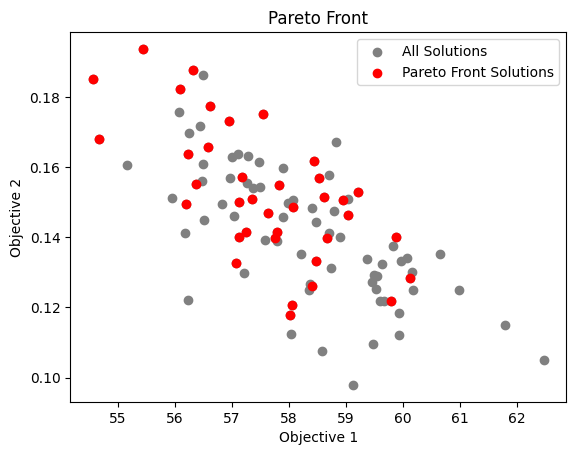

In [30]:
objectives_pareto = [ind.fitness.values for ind in hof2]
objectives_all = [ind.fitness.values for ind in pop]

plt.scatter([obj[0] for obj in objectives_all],
            [obj[1] for obj in objectives_all],
            c='grey', label='All Solutions')

plt.scatter([obj[0] for obj in objectives_pareto],
            [obj[1] for obj in objectives_pareto],
            c='red', label='Pareto Front Solutions')

plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.title('Pareto Front')
plt.legend()
plt.show()


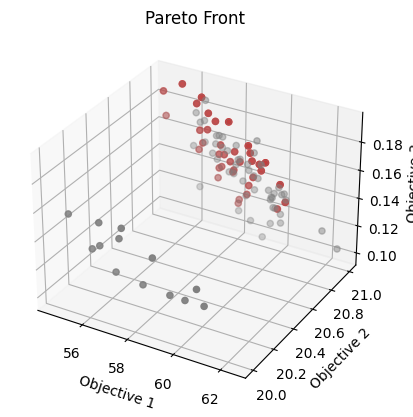

In [31]:


objectives = [ind.fitness.values for ind in hof2]
objectives_all = [ind.fitness.values for ind in pop]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([obj[0] for obj in objectives],
           [obj[3] for obj in objectives],
           [obj[1] for obj in objectives],
           c='red', label='Pareto Front Solutions')
ax.scatter([obj[0] for obj in objectives_all],
           [obj[3] for obj in objectives_all],
           [obj[1] for obj in objectives_all],
           c='grey', label='All Solutions')
ax.set_xlabel('Objective 1')
ax.set_ylabel('Objective 2')
ax.set_zlabel('Objective 3')
plt.title('Pareto Front')
plt.show()

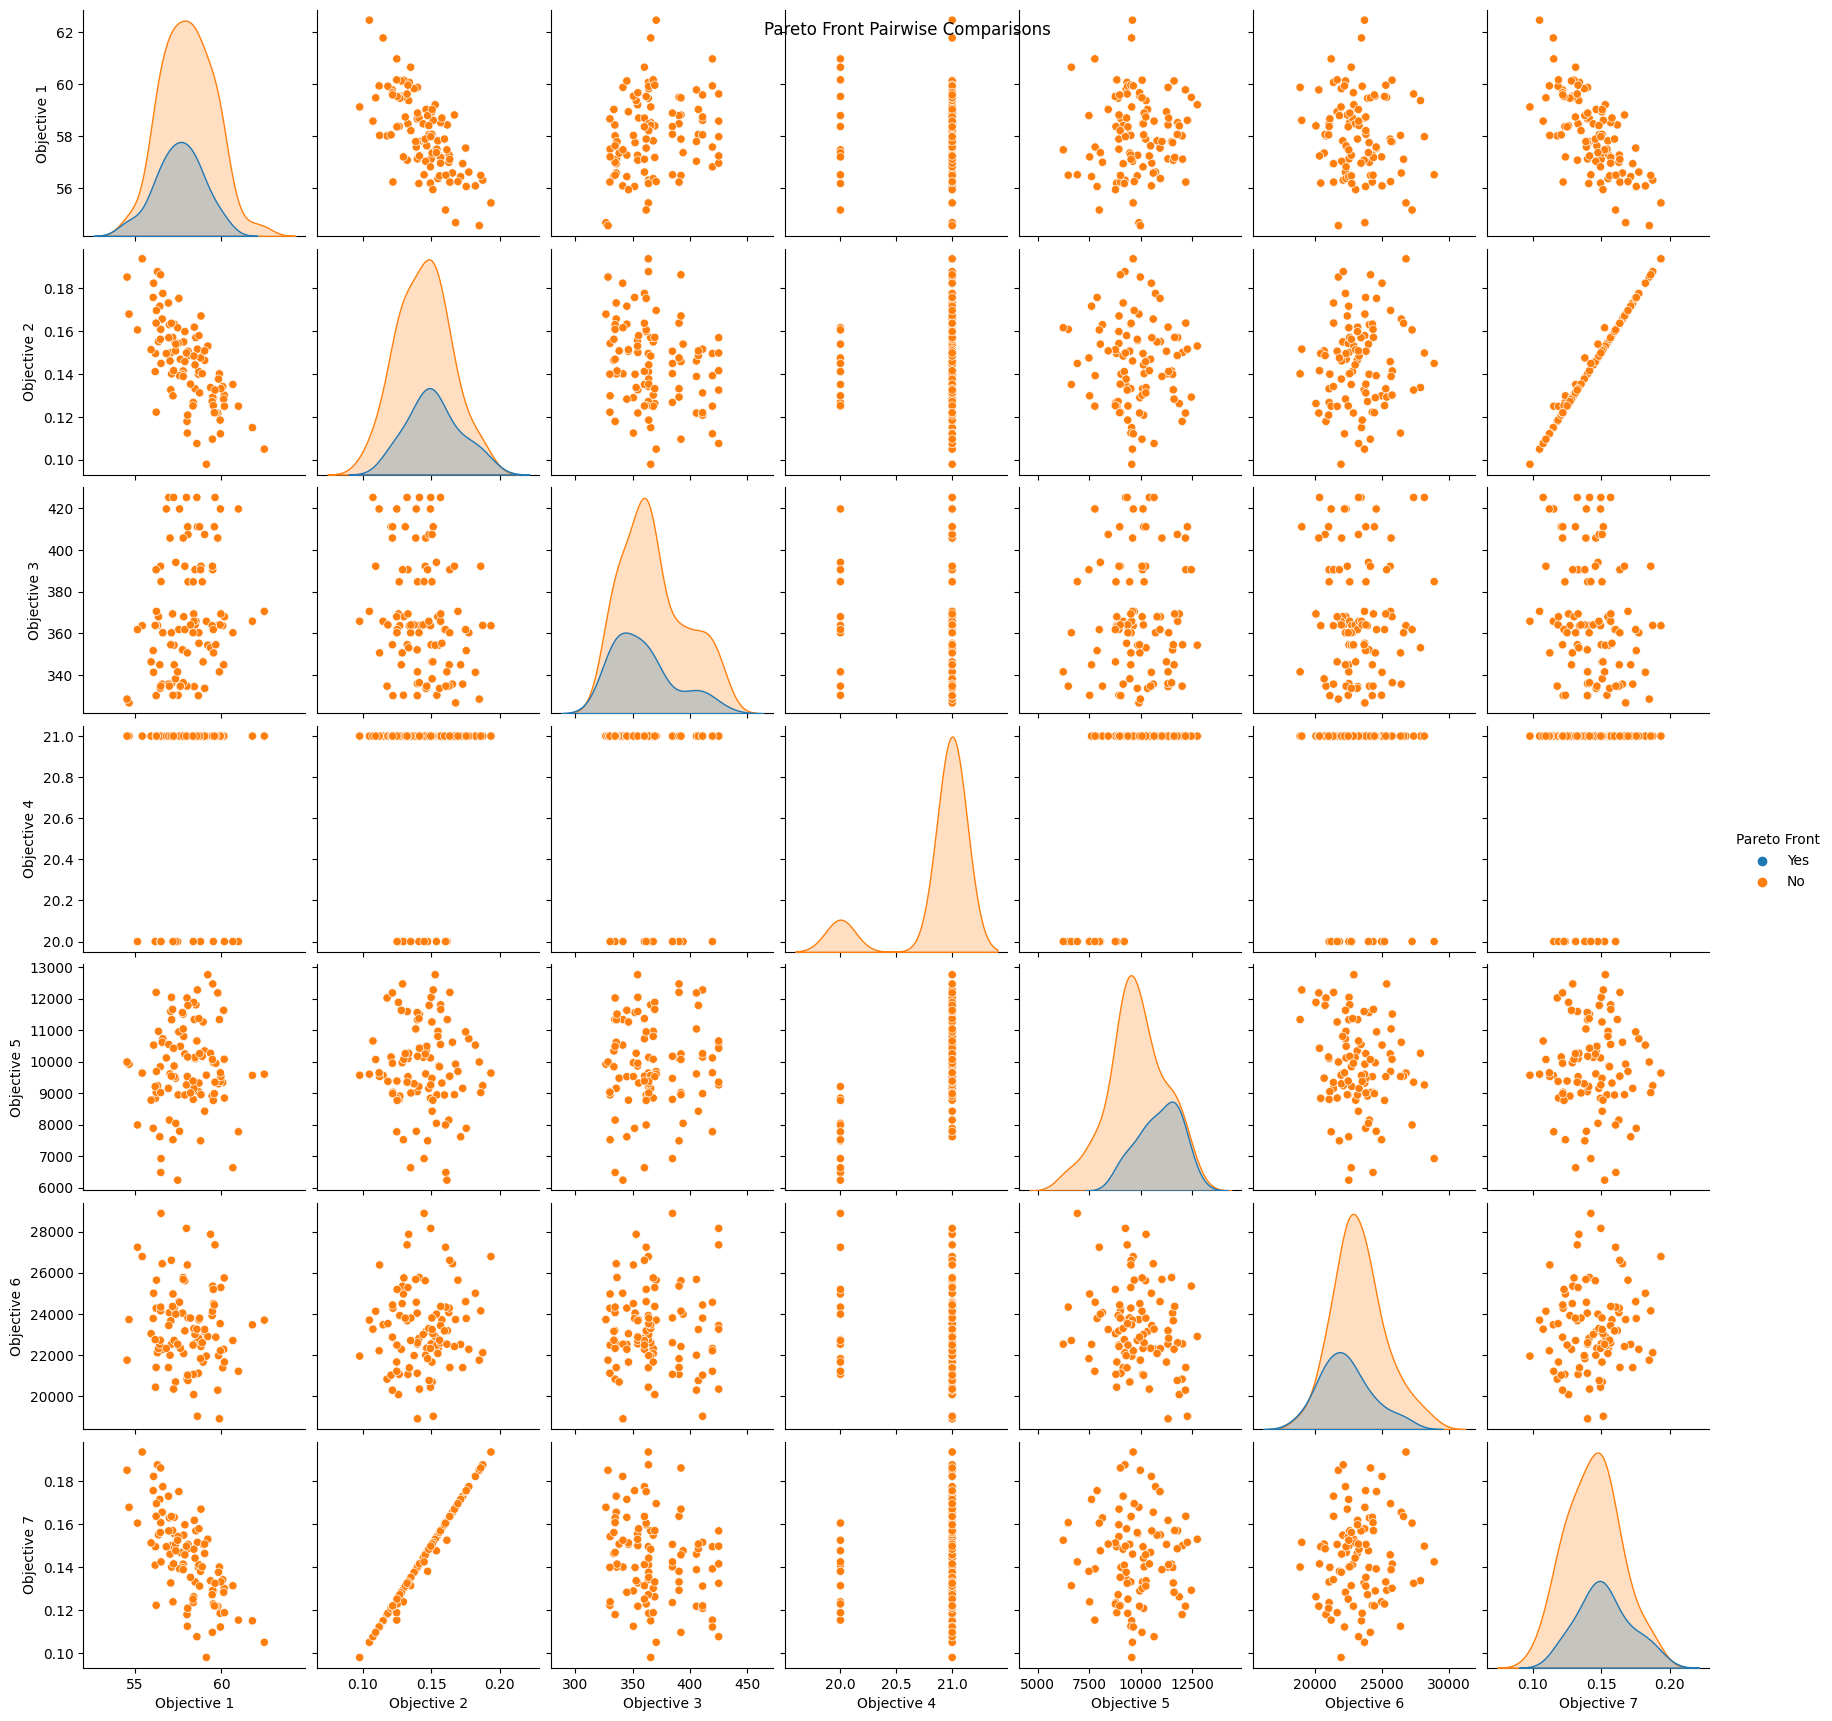

In [32]:
# Create DataFrame for Pareto front objectives
objectives_df = pd.DataFrame(objectives, columns=['Objective 1', 'Objective 2', 'Objective 3',
                                                  'Objective 4', 'Objective 5', 'Objective 6', 'Objective 7'])
objectives_df['Pareto Front'] = 'Yes'

# Create DataFrame for all population objectives
objectives_all_df = pd.DataFrame(objectives_all, columns=['Objective 1', 'Objective 2', 'Objective 3',
                                                          'Objective 4', 'Objective 5', 'Objective 6', 'Objective 7'])
objectives_all_df['Pareto Front'] = 'No'

# Concatenate both DataFrames
all_data = pd.concat([objectives_df, objectives_all_df])

# Plot using pairplot with hue based on the 'Pareto Front' column
sns.pairplot(all_data, hue='Pareto Front')
plt.suptitle('Pareto Front Pairwise Comparisons')
plt.show()


In [33]:

best_individual_solution = {home_lsoas[i]: site_codes[best_ind[i]] for i in range(len(best_ind))}

# Create a DataFrame from the best individual solution that maps home to site
home_to_site_df = pd.DataFrame(list(best_individual_solution.items()), columns=['HomeCode', 'SiteCode'])

# Initialize the total activity counts
total_activity_counts = defaultdict(lambda: [0, 0, 0])

# Iterate through the daily activities
for daily_df in daily_activities:
    # Merge the daily DataFrame with the home_to_site_df to add the site codes
    daily_with_site = daily_df.reset_index().merge(home_to_site_df, left_on='Der_Postcode_LSOA_Code', right_on='HomeCode')
    
    # Drop the SiteCode_x column and rename SiteCode_y to SiteCode
    daily_with_site.drop(columns=['HomeCode'], inplace=True)
    
    # Use pivot_table to compute the counts for each combination of site and activity level
    activity_counts_pivot = daily_with_site.pivot_table(index='SiteCode', columns='CC_Level', aggfunc='size', fill_value=0)

    # Update the total activity counts with the daily counts
    for site_code, counts in activity_counts_pivot.iterrows():
        total_activity_counts[site_code][0] += counts.get('NICU', 0)
        total_activity_counts[site_code][1] += counts.get('HDU', 0)
        total_activity_counts[site_code][2] += counts.get('SCBU', 0)

# Compute the average daily activity counts
average_daily_activity_counts = {site_code: [count / len(daily_activities) for count in counts] for site_code, counts in total_activity_counts.items()}

# Print the results
print("Average daily activity counts per site:")
print(average_daily_activity_counts)

Average daily activity counts per site:
{'E01007251': [1.3976470588235295, 2.352156862745098, 5.946666666666666], 'E01006512': [1.8133333333333332, 3.1380392156862746, 8.294901960784314], 'E01005164': [1.3027450980392157, 2.0164705882352942, 6.271372549019608], 'E01025104': [2.684705882352941, 4.71843137254902, 11.59686274509804], 'E01006370': [1.6015686274509804, 3.1866666666666665, 6.646274509803922], 'E01005801': [2.1694117647058824, 3.5207843137254904, 9.589803921568627], 'E01012722': [2.243137254901961, 3.7819607843137253, 9.232156862745098], 'E01005354': [2.247843137254902, 3.7137254901960786, 8.435294117647059], 'E01012457': [2.0964705882352943, 3.6784313725490194, 7.825882352941177], 'E01005944': [2.0376470588235294, 3.3780392156862744, 7.0988235294117645], 'E01006570': [2.4007843137254903, 4.171764705882353, 9.472941176470588], 'E01005070': [2.541176470588235, 3.9505882352941177, 9.291764705882352], 'E01004880': [2.8133333333333335, 4.84, 10.832156862745098], 'E01025300': [1.7

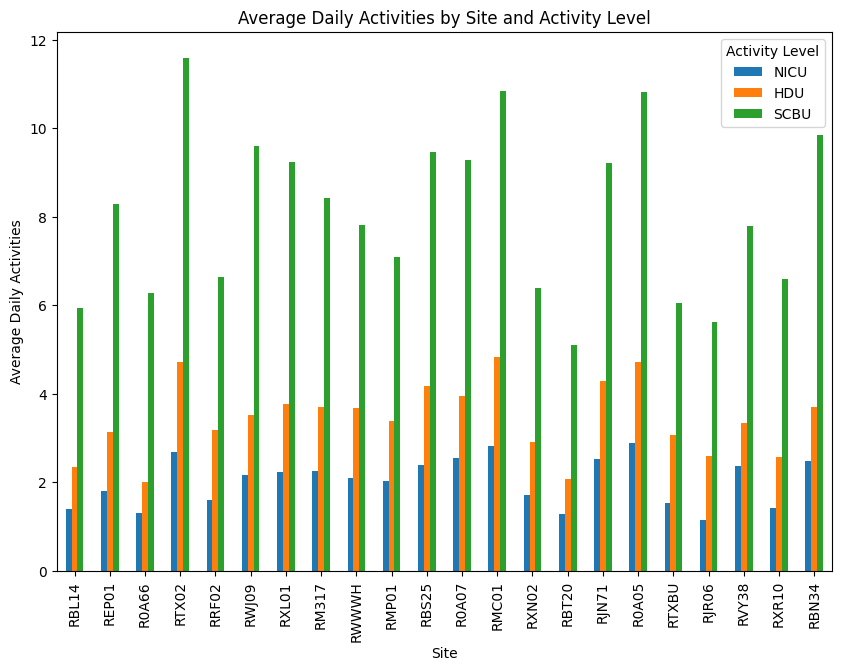

In [34]:
# Convert the average_daily_activity_counts dictionary into a DataFrame
average_daily_activities_df = pd.DataFrame.from_dict(average_daily_activity_counts, orient='index', columns=['NICU', 'HDU', 'SCBU'])

# Reset the index to make 'SiteCode' a column
average_daily_activities_df.reset_index(inplace=True)
average_daily_activities_df.rename(columns={'index': 'SiteCode'}, inplace=True)
average_daily_activities_df['SiteCode'] = average_daily_activities_df['SiteCode'].map(site_mapping)

# Plot the DataFrame directly using pandas plot function
average_daily_activities_df.set_index('SiteCode').plot(kind='bar', stacked=False, figsize=(10,7))

plt.title('Average Daily Activities by Site and Activity Level')
plt.xlabel('Site')
plt.ylabel('Average Daily Activities')
plt.legend(title='Activity Level')

plt.show()

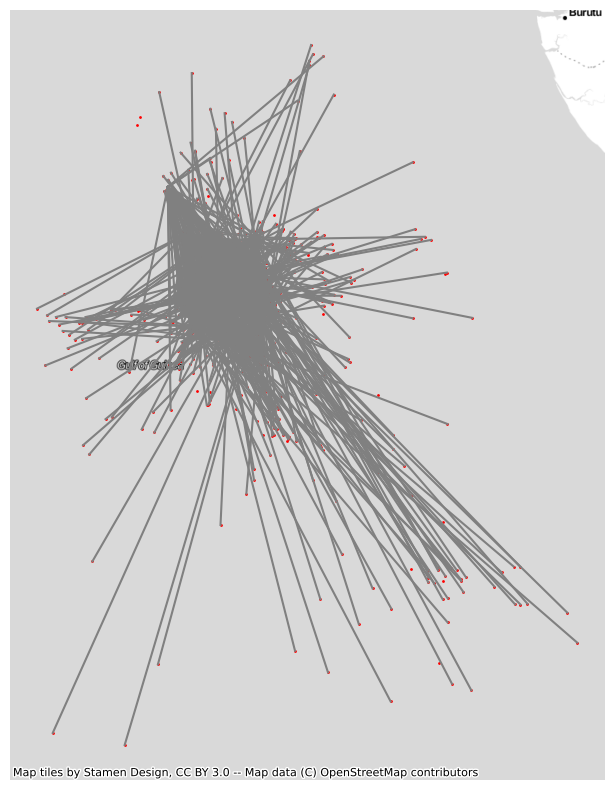

In [35]:
plot_assignments(pop[best_ind_id])  # Replace with the individual you want to plot

Lets look at it from a different starting point. We will create an extreme individual, as in our absolute travel time only solution and then use this as the starting point for our evolution, this should ensure that travel times are optimally accounted for at the beginning and we then begin to factor in our other priorities. 

For this we need to create this individual for our starting population and then make a few small changes to the other functions

In [36]:
def create_extreme_individual():
    # Create an individual that assigns each home to the nearest site
    individual = []
    for home_idx, home in enumerate(home_lsoas):
        nearest_site_idx = min(range(num_sites), key=lambda site_idx: travel_times_dict.get((home, site_codes[site_idx]), float('inf')))
        individual.append(nearest_site_idx)
    return creator.Individual(individual)

def init_population():
    population = []
    # Add the extreme individual
    population.append(create_extreme_individual())
    # Fill the rest of the population randomly
    for _ in range(pop_num - 1):
        population.append(create_extreme_individual())      #toolbox.individual())
    return population

# Register the initialization function
toolbox.register("population", init_population)

def main():
    random.seed(42)
    pop = toolbox.population()
    hof = tools.HallOfFame(1)
    hof2 = ParetoFront()

    # Define statistics for each objective
    stats_time = tools.Statistics(key=lambda ind: ind.fitness.values[0])
    stats_time.register("avg_time", np.mean)

    stats_prop = tools.Statistics(key=lambda ind: ind.fitness.values[1])
    stats_prop.register("prop_within_30_mins", np.max)
    
    stats_max_distance = tools.Statistics(key=lambda ind: ind.fitness.values[2])
    stats_max_distance.register("max_distance", np.max)
    
    stats_large_sites = tools.Statistics(key=lambda ind: ind.fitness.values[3])
    stats_large_sites.register("large_sites", np.max)
    
    smallest_site_stats = tools.Statistics(key=lambda ind: ind.fitness.values[4])
    smallest_site_stats.register("smallest_site", np.max)
    
    largest_site_stats = tools.Statistics(key=lambda ind: ind.fitness.values[5])
    largest_site_stats.register("largest_site", np.max)
    
    # Combine statistics into MultiStatistics
    mstats = tools.MultiStatistics(time=stats_time, prop=stats_prop, max_dist=stats_max_distance, large_sites=stats_large_sites,
                                   smallest_site=smallest_site_stats, largest_site=largest_site_stats)
    
    # Use mstats instead of the previous stats object
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=cross_chance, mutpb=mutation_prob, ngen=number_generations, 
                                   stats=mstats, halloffame=hof, verbose=False)
    
    # Manually update the Pareto front
    hof2.update(pop)
    
    return pop, log, hof, hof2

# Create the extreme individual
extreme_individual = create_extreme_individual()

# Evaluate the extreme individual using the eval_func
fitness_values = eval_func(extreme_individual)

# Extract the average travel time from the fitness values
avg_time_for_extreme_individual = fitness_values[0]

print(f"The average travel time for the extreme individual is {avg_time_for_extreme_individual} minutes.")


The average travel time for the extreme individual is 15.359279966153844 minutes.


And then re run and re-visualise our new results, as we are starting with only one extreme individual, let's turn up our mutation chance as we will be relying on mutation for any variation in the beginning

In [37]:
mutation_prob = 0.25

pop, log, hof, hof2 = main()
#print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
fitnesses = [ind.fitness for ind in pop]
best_ind_id = fitnesses.index(max(fitnesses))
best_ind = pop[best_ind_id]
print(f"Best individual is at index {best_ind_id} with fitness: {best_ind.fitness}")

Best individual is at index 0 with fitness: (47.59373447507673, 0.3536210594353204, 329.0475418, 21.0, 10129.0, 21327.0, 0.3536210594353204)


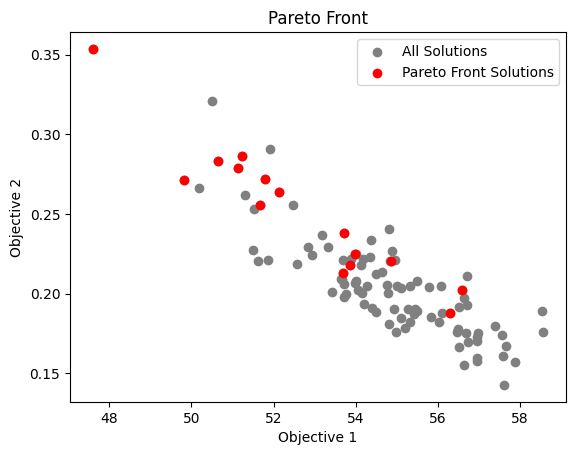

In [38]:
objectives_pareto = [ind.fitness.values for ind in hof2]
objectives_all = [ind.fitness.values for ind in pop]

plt.scatter([obj[0] for obj in objectives_all],
            [obj[1] for obj in objectives_all],
            c='grey', label='All Solutions')

plt.scatter([obj[0] for obj in objectives_pareto],
            [obj[1] for obj in objectives_pareto],
            c='red', label='Pareto Front Solutions')

plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.title('Pareto Front')
plt.legend()
plt.show()

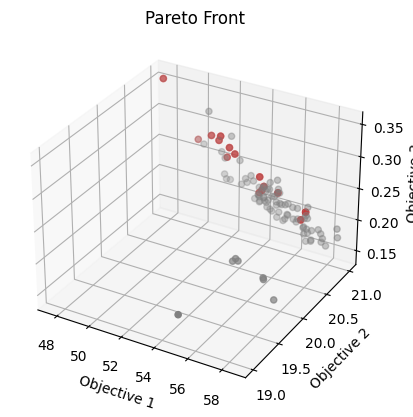

In [39]:
objectives = [ind.fitness.values for ind in hof2]
objectives_all = [ind.fitness.values for ind in pop]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([obj[0] for obj in objectives],
           [obj[3] for obj in objectives],
           [obj[1] for obj in objectives],
           c='red', label='Pareto Front Solutions')
ax.scatter([obj[0] for obj in objectives_all],
           [obj[3] for obj in objectives_all],
           [obj[1] for obj in objectives_all],
           c='grey', label='All Solutions')
ax.set_xlabel('Objective 1')
ax.set_ylabel('Objective 2')
ax.set_zlabel('Objective 3')
plt.title('Pareto Front')
plt.show()

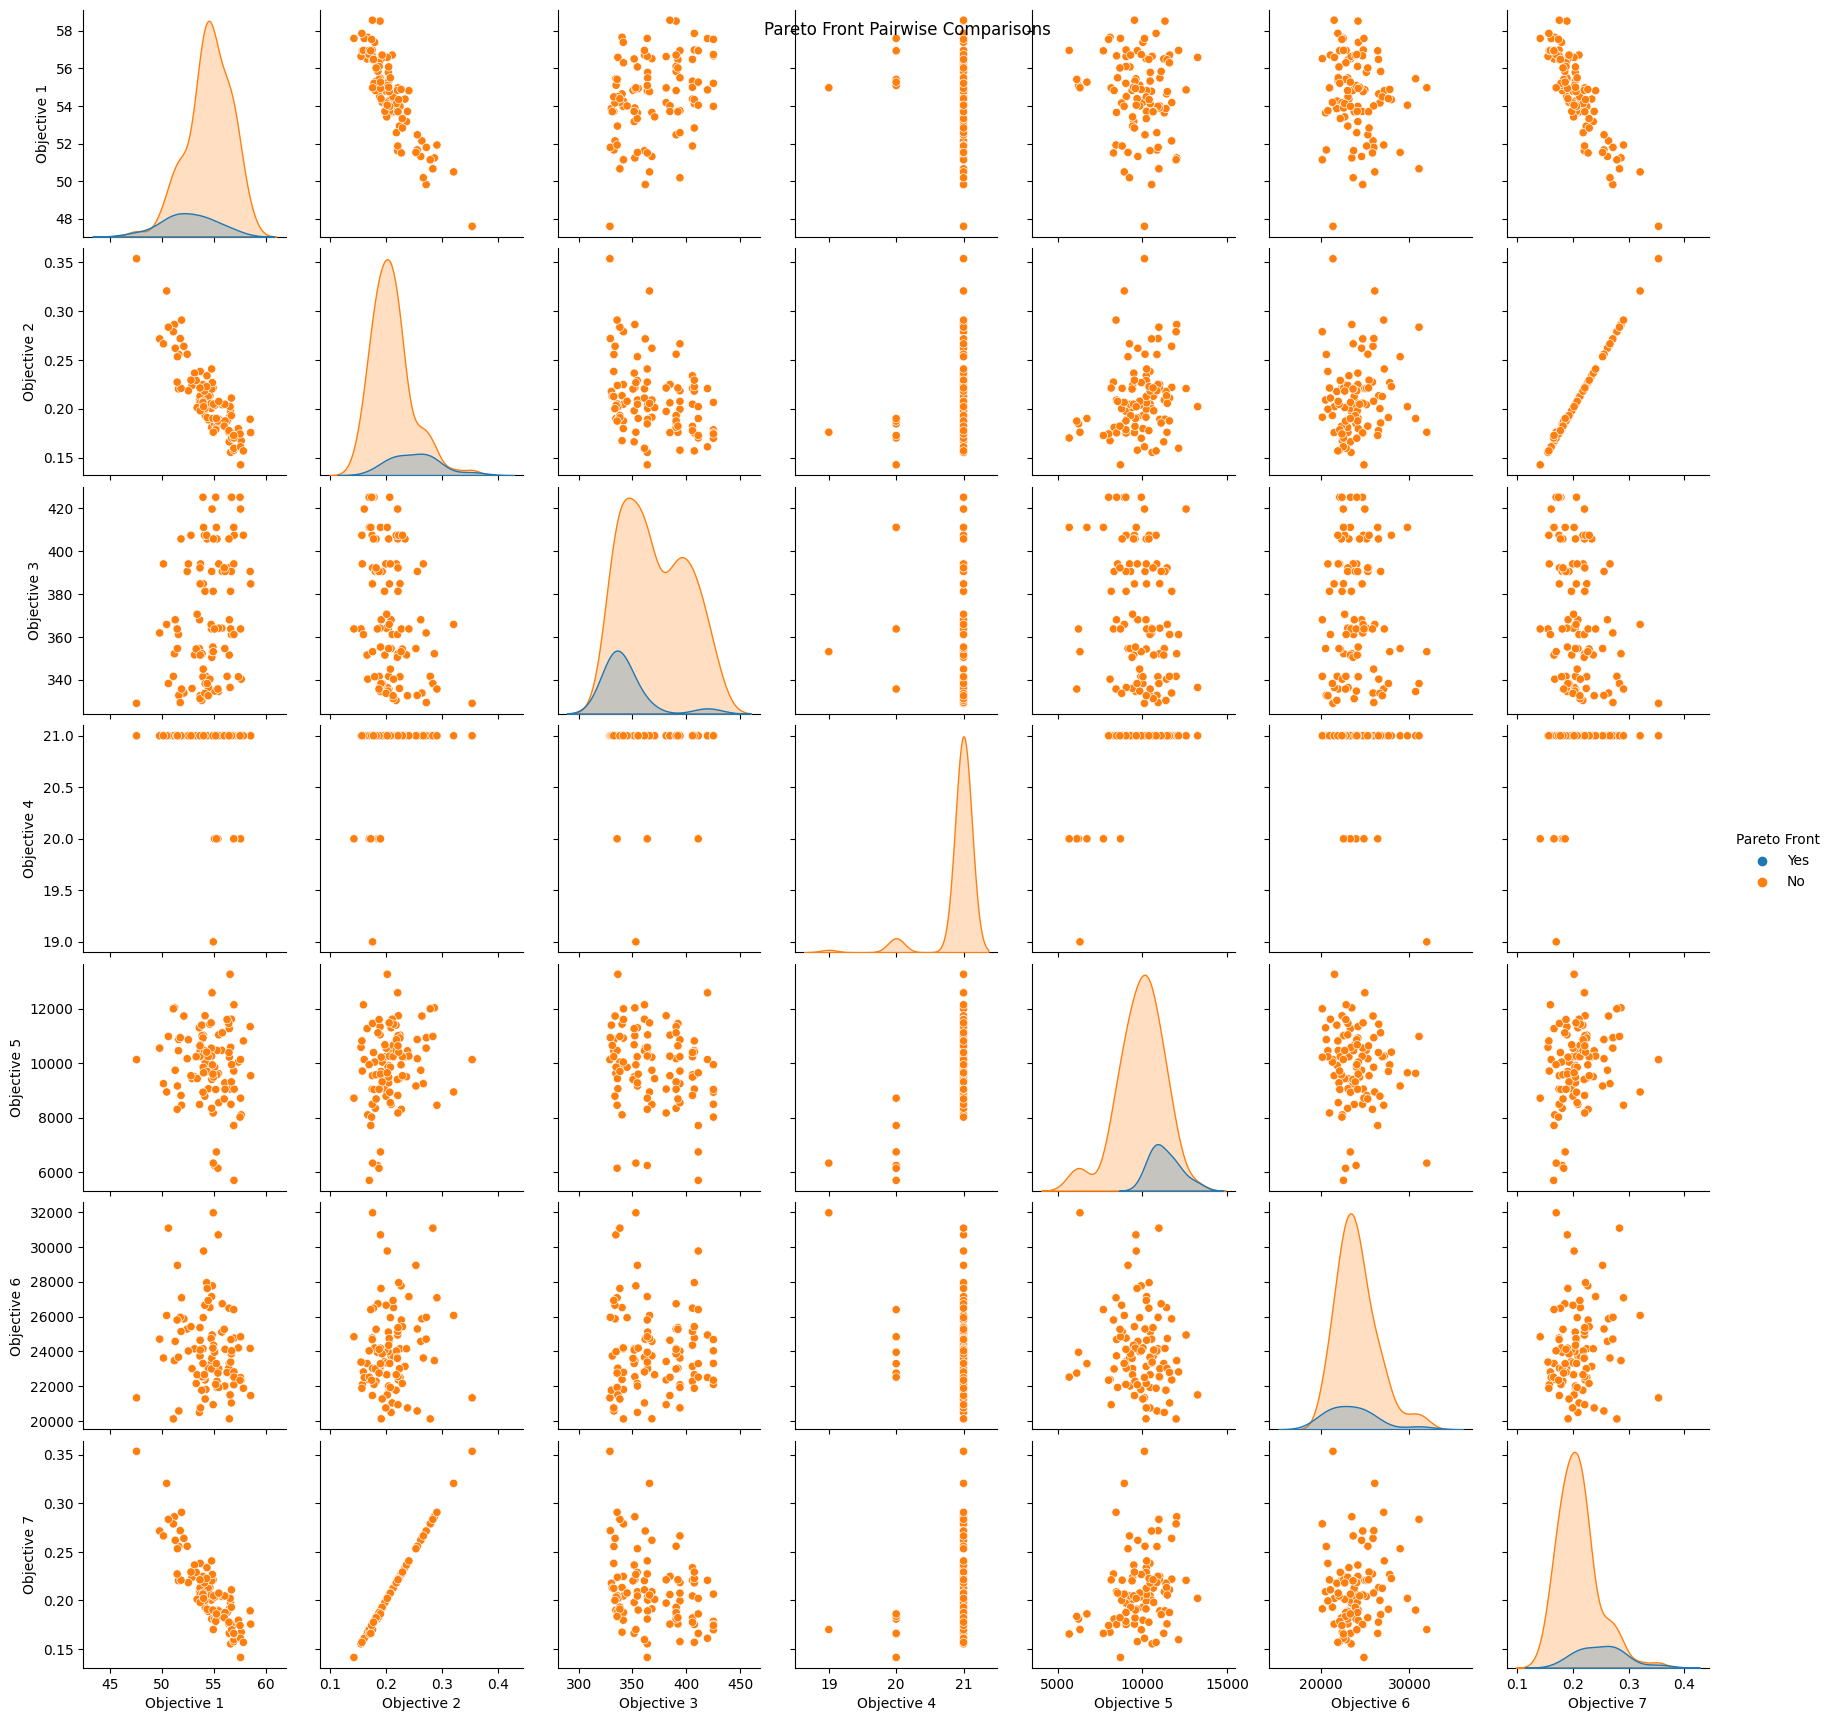

In [40]:
# Create DataFrame for Pareto front objectives
objectives_df = pd.DataFrame(objectives, columns=['Objective 1', 'Objective 2', 'Objective 3',
                                                  'Objective 4', 'Objective 5', 'Objective 6', 'Objective 7'])
objectives_df['Pareto Front'] = 'Yes'

# Create DataFrame for all population objectives
objectives_all_df = pd.DataFrame(objectives_all, columns=['Objective 1', 'Objective 2', 'Objective 3',
                                                          'Objective 4', 'Objective 5', 'Objective 6', 'Objective 7'])
objectives_all_df['Pareto Front'] = 'No'

# Concatenate both DataFrames
all_data = pd.concat([objectives_df, objectives_all_df])

# Plot using pairplot with hue based on the 'Pareto Front' column
sns.pairplot(all_data, hue='Pareto Front')
plt.suptitle('Pareto Front Pairwise Comparisons')
plt.show()

In [41]:
best_individual_solution = {home_lsoas[i]: site_codes[best_ind[i]] for i in range(len(best_ind))}

# Create a DataFrame from the best individual solution that maps home to site
home_to_site_df = pd.DataFrame(list(best_individual_solution.items()), columns=['HomeCode', 'SiteCode'])

# Initialize the total activity counts
total_activity_counts = defaultdict(lambda: [0, 0, 0])

# Iterate through the daily activities
for daily_df in daily_activities:
    # Merge the daily DataFrame with the home_to_site_df to add the site codes
    daily_with_site = daily_df.reset_index().merge(home_to_site_df, left_on='Der_Postcode_LSOA_Code', right_on='HomeCode')
    
    # Drop the SiteCode_x column and rename SiteCode_y to SiteCode
    daily_with_site.drop(columns=['HomeCode'], inplace=True)
    
    # Use pivot_table to compute the counts for each combination of site and activity level
    activity_counts_pivot = daily_with_site.pivot_table(index='SiteCode', columns='CC_Level', aggfunc='size', fill_value=0)

    # Update the total activity counts with the daily counts
    for site_code, counts in activity_counts_pivot.iterrows():
        total_activity_counts[site_code][0] += counts.get('NICU', 0)
        total_activity_counts[site_code][1] += counts.get('HDU', 0)
        total_activity_counts[site_code][2] += counts.get('SCBU', 0)

# Compute the average daily activity counts
average_daily_activity_counts = {site_code: [count / len(daily_activities) for count in counts] for site_code, counts in total_activity_counts.items()}

# Print the results
print("Average daily activity counts per site:")
print(average_daily_activity_counts)

Average daily activity counts per site:
{'E01019155': [2.6164705882352943, 3.1223529411764708, 7.1647058823529415], 'E01005944': [2.4180392156862744, 4.024313725490196, 10.228235294117647], 'E01025300': [2.2533333333333334, 4.076078431372549, 8.734901960784313], 'E01006499': [1.5670588235294118, 3.065098039215686, 6.709019607843137], 'E01006570': [2.0125490196078433, 3.7827450980392157, 9.637647058823529], 'E01005070': [2.2023529411764704, 3.844705882352941, 9.88], 'E01018480': [1.68078431372549, 3.7066666666666666, 7.676078431372549], 'E01005062': [2.3529411764705883, 4.0588235294117645, 10.474509803921569], 'E01012722': [1.8290196078431373, 3.7137254901960786, 8.784313725490197], 'E01005354': [2.0376470588235294, 2.743529411764706, 6.974117647058823], 'E01004880': [2.468235294117647, 4.214901960784314, 10.72549019607843], 'E01024897': [2.3145098039215686, 3.3254901960784315, 7.961568627450981], 'E01006512': [2.2650980392156863, 3.2494117647058824, 6.4101960784313725], 'E01006370': [2

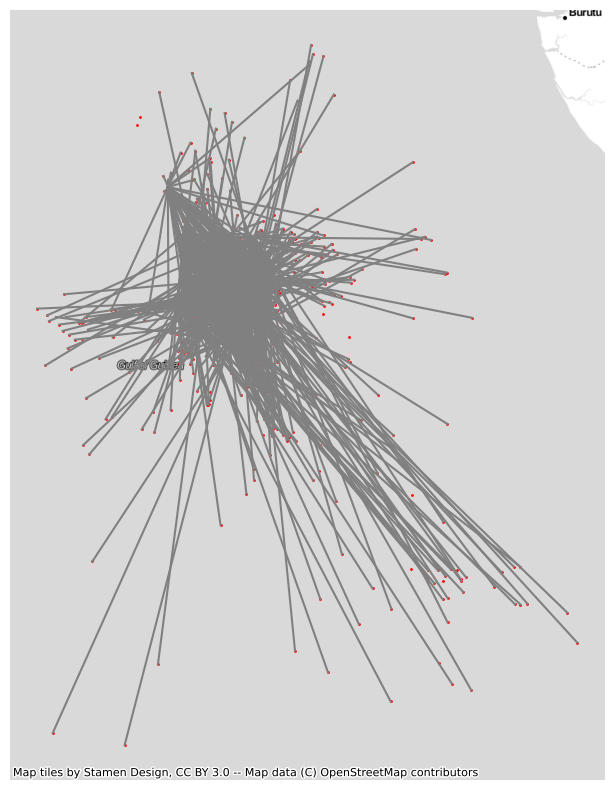

In [42]:
plot_assignments(pop[best_ind_id])  # Replace with the individual you want to plot

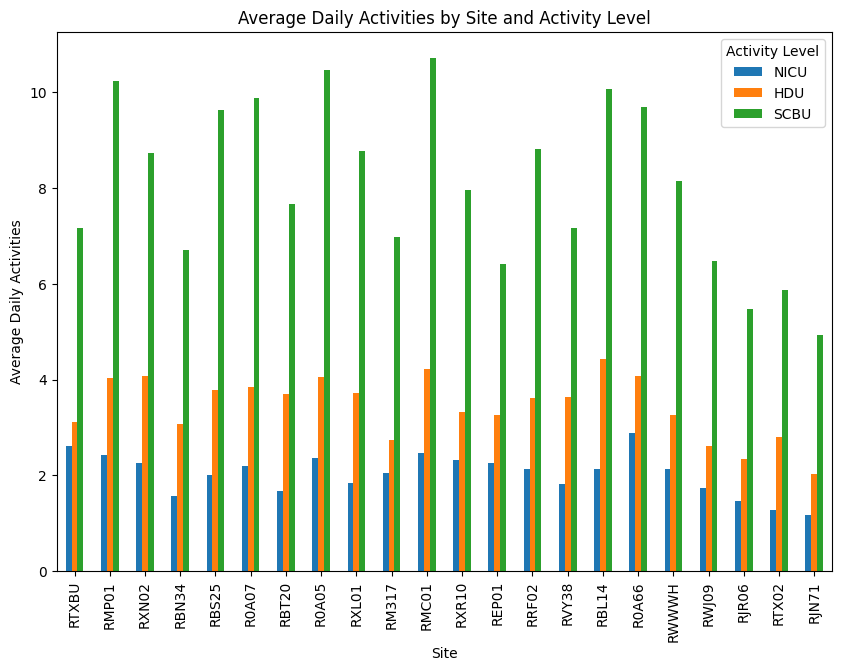

In [43]:
# Convert the average_daily_activity_counts dictionary into a DataFrame
average_daily_activities_df = pd.DataFrame.from_dict(average_daily_activity_counts, orient='index', columns=['NICU', 'HDU', 'SCBU'])

# Reset the index to make 'SiteCode' a column
average_daily_activities_df.reset_index(inplace=True)
average_daily_activities_df.rename(columns={'index': 'SiteCode'}, inplace=True)
average_daily_activities_df['SiteCode'] = average_daily_activities_df['SiteCode'].map(site_mapping)

# Plot the DataFrame directly using pandas plot function
average_daily_activities_df.set_index('SiteCode').plot(kind='bar', stacked=False, figsize=(10,7))

plt.title('Average Daily Activities by Site and Activity Level')
plt.xlabel('Site')
plt.ylabel('Average Daily Activities')
plt.legend(title='Activity Level')

plt.show()

In [44]:
average_daily_activities_df

,SiteCode,NICU,HDU,SCBU
0,RTXBU,2.616471,3.122353,7.164706
1,RMP01,2.418039,4.024314,10.228235
2,RXN02,2.253333,4.076078,8.734902
3,RBN34,1.567059,3.065098,6.709020
4,RBS25,2.012549,3.782745,9.637647
5,R0A07,2.202353,3.844706,9.880000
6,RBT20,1.680784,3.706667,7.676078
7,R0A05,2.352941,4.058824,10.474510
8,RXL01,1.829020,3.713725,8.784314
9,RM317,2.037647,2.743529,6.974118
